# Customer Service Data Clustering

## TF-IDF Clustering

In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE

### Configuration

In [2]:
path = os.path.join("..","data","./newdata_clean.xlsx")
n_clusters = 12
batch_size = 10000
max_k = 40
max_features = 256  # only consider the top max_features ordered by term frequency across the corpus.

### Read Data

In [3]:
df = pd.read_excel(path)

df = df.dropna() # drop nan entry
# df[pd.isnull(df).any(axis=1)]

le = preprocessing.LabelEncoder()
le.fit(df['catName'].unique())
num_classes = len(le.classes_)
class_list = list(le.classes_)

#print(class_list)

print("number of classes:",num_classes)
df.loc[:,'catName'] = le.transform(df.loc[:,'catName'])
data = df.question

number of classes: 64


### Preprocess Data

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

import langid

from nltk.corpus import stopwords

stw = stopwords.words('english') + ['nbsp', 'powerdirector', 'cyberlink', 'powerdvd', 'power', 'director', 'ba']
#print(stw)
print("Stopwords length: {}".format(len(stw)))

def _filter(ori_x):
    x = re.sub('<[^<]*?/?>', ' ', ori_x)        # remove all html tag
    x = re.sub('https?:\/\/[^ ]*', ' ', x)  # remove all url
    x = re.sub('\S*@\S*\s?', ' ', x)        # remove all email address
    x = re.sub('\S*\.\S*\s?', ' ', x, flags=re.IGNORECASE)        # remove all filename
    x = re.sub('[^a-z A-Z]', ' ', x)        # remove all non-english alphabat
    return x
'''
def _correct_word(text1):
    pattern = re.compile(r"(.)\1{2,}")
    text2 = pattern.sub(r"\1\1", text1) # reduce lengthening
    #if text1 != text2:
    #    print(text1, text2)
    text3 = spell(text2).lower() # spell correction
    #if text2 != text3:
    #    print(text2, text3)
    return text3
'''
def _get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def _lemmatization(tokens):
    tagged_sent = pos_tag(tokens)   
    ret = []
    for tag in tagged_sent:
        wordnet_pos = _get_wordnet_pos(tag[1]) or wordnet.NOUN
        ret.append(wnl.lemmatize(tag[0], pos=wordnet_pos))
    return ret

def _remove_stopword(tokens):
    ret = []
    for word in tokens:
        if word not in stw and len(word) > 2:
            ret.append(word)
    return ret

def preprocess(sentence):
    sentence = _filter(sentence.lower())
    tokens = nltk.word_tokenize(sentence)

    #tokens = [self._correct_word(word) for word in tokens] # spell correction
    tokens = _lemmatization(tokens) # lemmatization
    tokens = _remove_stopword(tokens) # remove stopwords
    s = " ".join(tokens)

    return s, tokens

from tqdm import tqdm
clean_data = []
reduced_data = []
token_data = []

for s in tqdm(data):
    ret = langid.classify(s)
    if ret[0] != "en" and ret[1] < -100: # remove language other than english
        #print(ret)
        #print(s)
        continue
    else:
        processed, tokens = preprocess(s)
        #print(processed)
        #print(tokens)
        reduced_data.append(s)
        clean_data.append(processed)
        token_data.append(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/student/05/b05505004/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/05/b05505004/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

  0%|          | 12/106478 [00:00<15:05, 117.58it/s]

Stopwords length: 186



  2%|▏         | 2605/106478 [00:17<09:18, 186.05it/s]


  5%|▍         | 5166/106478 [00:33<13:13, 127.75it/s]


  7%|▋         | 7682/106478 [00:50<10:32, 156.26it/s]


 10%|▉         | 10272/106478 [01:06<12:13, 131.22it/s]


 12%|█▏        | 12740/106478 [01:23<11:06, 140.63it/s]


 14%|█▍        | 15226/106478 [01:40<10:12, 148.87it/s]


 17%|█▋        | 17595/106478 [01:57<12:20, 119.95it/s]


 19%|█▉        | 20157/106478 [02:13<14:48, 97.16it/s] 


 22%|██▏       | 22983/106478 [02:31<07:28, 186.04it/s]


 25%|██▍       | 26134/106478 [02:48<07:24, 180.63it/s]


 27%|██▋       | 29121/106478 [03:06<05:40, 227.03it/s]


 30%|███       | 32147/106478 [03:23<10:12, 121.33it/s]


 33%|███▎      | 34862/106478 [03:41<07:59, 149.45it/s]


 35%|███▌      | 37388/106478 [03:58<07:15, 158.47it/s]


 37%|███▋      | 39628/106478 [04:15<07:30, 148.51it/s]


 39%|███▉      | 41815/106478 [04:31<10:04, 106.91it/s]


 41%|████▏     | 43977/106478 [04:47<06:49, 152.46it/s]


 43%|████▎     | 46217/106478 [05:03<08:50, 113.57it/s]


 46%|████▌     | 48504/106478 [05:19<06:38, 145.49it/s]


 48%|████▊     | 50816/106478 [05:35<06:00, 154.58it/s]


 50%|████▉     | 53154/106478 [05:51<06:48, 130.50it/s]


 52%|█████▏    | 55675/106478 [06:08<05:24, 156.73it/s]


 55%|█████▍    | 58116/106478 [06:24<04:35, 175.46it/s]


 56%|█████▋    | 60101/106478 [06:41<08:31, 90.64it/s]


 58%|█████▊    | 62020/106478 [06:57<06:34, 112.64it/s]


 60%|██████    | 63925/106478 [07:13<05:18, 133.70it/s]


 62%|██████▏   | 66177/106478 [07:29<05:18, 126.64it/s]


 64%|██████▍   | 68491/106478 [07:45<04:43, 133.89it/s]


 66%|██████▋   | 70564/106478 [08:01<05:13, 114.54it/s]


 68%|██████▊   | 72439/106478 [08:18<03:00, 188.32it/s]


 70%|███████   | 74826/106478 [08:34<04:13, 124.70it/s]


 72%|███████▏  | 76652/106478 [08:50<05:41, 87.24it/s] 


 74%|███████▍  | 79156/106478 [09:06<02:53, 157.31it/s]


 76%|███████▌  | 80993/106478 [09:22<03:41, 114.95it/s]


 78%|███████▊  | 83171/106478 [09:38<03:29, 111.51it/s]


 80%|███████▉  | 84868/106478 [09:54<04:26, 81.14it/s]


 82%|████████▏ | 87032/106478 [10:10<01:33, 207.46it/s]


 84%|████████▍ | 89387/106478 [10:26<02:06, 135.46it/s]


 86%|████████▌ | 91445/106478 [10:42<01:31, 163.44it/s]


 88%|████████▊ | 93636/106478 [10:59<01:36, 132.80it/s]


 90%|████████▉ | 95641/106478 [11:15<01:16, 142.11it/s]


 92%|█████████▏| 98129/106478 [11:31<01:09, 119.33it/s]


 94%|█████████▍| 100379/106478 [11:47<00:37, 163.59it/s]


 96%|█████████▋| 102680/106478 [12:03<00:27, 140.18it/s]


 98%|█████████▊| 104869/106478 [12:19<00:10, 148.02it/s]


100%|██████████| 106478/106478 [12:31<00:00, 141.62it/s]

In [6]:
print("max_feature",max_features)
tfidf = TfidfVectorizer(
    min_df = 0.001,
    max_df = 0.95,
    max_features = max_features,
    stop_words = 'english'
)
tfidf.fit(clean_data)
text = tfidf.transform(clean_data)

max_feature 256



Fit 40 clusters: 100%|██████████| 20/20 [00:13<00:00,  1.04s/it]

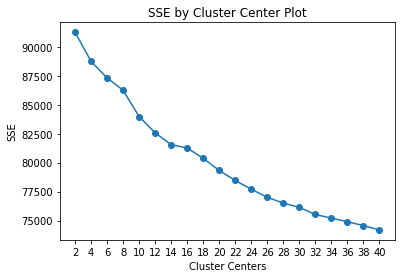

In [7]:
def find_optimal_clusters(data, max_k, batch_size):
    iters = range(2, max_k+1, 2)
    
    sse = []
    bar = tqdm(iters)
    for k in bar:
        sse.append(MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=20).fit(data).inertia_)
        bar.set_description('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

find_optimal_clusters(text, max_k, batch_size)

Compute cluster centers and predict cluster index for each sample.

In [8]:
clusters = MiniBatchKMeans(n_clusters=10, batch_size=batch_size, random_state=20).fit_predict(text)

In [9]:
def plot_tsne_pca(data, labels):
    n_cpu = 15
    n_data = data.shape[0]
    
    # number of clusters
    max_label = max(labels) 
    print("Number of clusters: {}".format(max_label + 1))
    
    # random sample (n_sample) points
    np.random.seed(5)
    n_sample = n_data // 10
    print("Only calculate {} data points".format(n_sample))
    sample_items = np.random.choice(range(n_data), size=n_sample, replace=False)
    npdata = data[sample_items,:]
    
    pca = PCA(n_components=2, whiten=True).fit_transform(npdata)
    print("PCA done")
    
    tsne_pca = TSNE(n_jobs=n_cpu, n_iter=5000).fit_transform(PCA(n_components=(max_features // 2)).fit_transform(npdata))
    print("tsne_pca done")
    tsne = TSNE(n_jobs=n_cpu, n_iter=5000).fit_transform(npdata)
    print("tsne30 done")
    tsne_per50 = TSNE(n_jobs=n_cpu, perplexity=50, n_iter=5000).fit_transform(npdata)
    print("tsne50 done")
    '''
    tsne_per80 = TSNE(n_jobs=n_cpu, perplexity=80, n_iter=5000).fit_transform(npdata)
    print("tsne80 done")
    tsne_per100 = TSNE(n_jobs=n_cpu, perplexity=100, n_iter=5000).fit_transform(npdata)
    print("tsne100 done")
    
    tsne_per3001 = TSNE(n_jobs=n_cpu, perplexity=30, n_iter=100).fit_transform(npdata)
    print("tsne_per3001 done")
    tsne_per3005 = TSNE(n_jobs=n_cpu, perplexity=30, n_iter=500).fit_transform(npdata)
    print("tsne_per3005 done")
    tsne_per301 = TSNE(n_jobs=n_cpu, perplexity=30, n_iter=1000).fit_transform(npdata)
    print("tsne301 done")
    tsne_per302 = TSNE(n_jobs=n_cpu, perplexity=30, n_iter=2000).fit_transform(npdata)
    print("tsne302 done")
    tsne_per303 = TSNE(n_jobs=n_cpu, perplexity=30, n_iter=3000).fit_transform(npdata)
    print("tsne303 done")
    tsne_per304 = TSNE(n_jobs=n_cpu, perplexity=30, n_iter=4000).fit_transform(npdata)
    print("tsne304 done")
    tsne_per306 = TSNE(n_jobs=n_cpu, perplexity=30, n_iter=6000).fit_transform(npdata)
    print("tsne306 done")
    tsne_per307 = TSNE(n_jobs=n_cpu, perplexity=30, n_iter=7000).fit_transform(npdata)
    print("tsne307 done")
    tsne_per308 = TSNE(n_jobs=n_cpu, perplexity=30, n_iter=8000).fit_transform(npdata)
    print("tsne308 done")
    tsne_per309 = TSNE(n_jobs=n_cpu, perplexity=30, n_iter=9000).fit_transform(npdata)
    print("tsne309 done")
    tsne_per3010 = TSNE(n_jobs=n_cpu, perplexity=30, n_iter=10000).fit_transform(npdata)
    print("tsne3010 done")
    '''
    
    # draw only (n_draw) points
    np.random.seed(5)
    n_draw = n_sample // 20
    print("Only draw {} data points".format(n_draw))
    idx = np.random.choice(range(pca.shape[0]), size=n_draw, replace=False)
    
    label_subset = labels[sample_items]
    
    # draw scatter
    f, ax = plt.subplots(2, 2, figsize=(14, 14))
    for i in range(max_label + 1):
        sub_idx = idx[label_subset[idx] == i]
        print("")
        label_subset_color = np.array([cm.hsv(i/ ( max_label + 1)) for i in label_subset[sub_idx]])
        ax[0,0].scatter(pca[sub_idx, 0], pca[sub_idx, 1])   # , c=label_subset_color
        ax[0,0].set_title('PCA Cluster Plot')
        
        ax[1,0].set_title('t-SNE & PCA Cluster Plot')
        ax[1,0].scatter(tsne_pca[sub_idx, 0], tsne_pca[sub_idx, 1], label=str(i)) # , c=label_subset_color
        
        ax[0,1].set_title('t-SNE Cluster Plot')
        ax[0,1].scatter(tsne[sub_idx, 0], tsne[sub_idx, 1]) # , c=label_subset_color
        
        ax[1,1].set_title('t-SNE Cluster Plot (Perplexity 50)')
        ax[1,1].scatter(tsne_per50[sub_idx, 0], tsne_per50[sub_idx, 1]) # , c=label_subset_color
        '''
        ax[2,0].set_title('t-SNE Cluster Plot (Perplexity 80)')
        ax[2,0].scatter(tsne_per80[sub_idx, 0], tsne_per80[sub_idx, 1]) # , c=label_subset_color
        
        ax[2,1].set_title('t-SNE Cluster Plot (Perplexity 100)')
        ax[2,1].scatter(tsne_per100[sub_idx, 0], tsne_per100[sub_idx, 1]) # , c=label_subset_color
        
        ax[3,0].set_title('t-SNE Cluster Plot (Perplexity 30 100)')
        ax[3,0].scatter(tsne_per3001[sub_idx, 0], tsne_per3001[sub_idx, 1]) # , c=label_subset_color
        ax[3,1].set_title('t-SNE Cluster Plot (Perplexity 30 500)')
        ax[3,1].scatter(tsne_per3005[sub_idx, 0], tsne_per3005[sub_idx, 1]) # , c=label_subset_color
       
        ax[4,0].set_title('t-SNE Cluster Plot (Perplexity 30 1000)')
        ax[4,0].scatter(tsne_per301[sub_idx, 0], tsne_per301[sub_idx, 1]) # , c=label_subset_color
        ax[4,1].set_title('t-SNE Cluster Plot (Perplexity 30 2000)')
        ax[4,1].scatter(tsne_per302[sub_idx, 0], tsne_per302[sub_idx, 1]) # , c=label_subset_color
         
        ax[5,0].set_title('t-SNE Cluster Plot (Perplexity 30 3000)')
        ax[5,0].scatter(tsne_per303[sub_idx, 0], tsne_per303[sub_idx, 1]) # , c=label_subset_color
        ax[5,1].set_title('t-SNE Cluster Plot (Perplexity 30 4000)')
        ax[5,1].scatter(tsne_per304[sub_idx, 0], tsne_per304[sub_idx, 1]) # , c=label_subset_color
        
        ax[6,0].set_title('t-SNE Cluster Plot (Perplexity 30 6000)')
        ax[6,0].scatter(tsne_per306[sub_idx, 0], tsne_per306[sub_idx, 1]) # , c=label_subset_color
        ax[6,1].set_title('t-SNE Cluster Plot (Perplexity 30 7000)')
        ax[6,1].scatter(tsne_per307[sub_idx, 0], tsne_per307[sub_idx, 1]) # , c=label_subset_color
        
        ax[7,0].set_title('t-SNE Cluster Plot (Perplexity 30 8000)')
        ax[7,0].scatter(tsne_per308[sub_idx, 0], tsne_per308[sub_idx, 1]) # , c=label_subset_color
        ax[7,1].set_title('t-SNE Cluster Plot (Perplexity 30 9000)')
        ax[7,1].scatter(tsne_per309[sub_idx, 0], tsne_per309[sub_idx, 1]) # , c=label_subset_color
        
        ax[8,0].set_title('t-SNE Cluster Plot (Perplexity 30 10000)')
        ax[8,0].scatter(tsne_per3010[sub_idx, 0], tsne_per3010[sub_idx, 1]) # , c=label_subset_color
        '''
    f.legend() # plot only one legend

text shape: (104034, 256)
clusters: (104034,) [6 3 2 ... 2 9 8]
Number of clusters: 10
Only calculate 10403 data points
PCA done
tsne_pca done
tsne30 done
tsne50 done
Only draw 520 data points












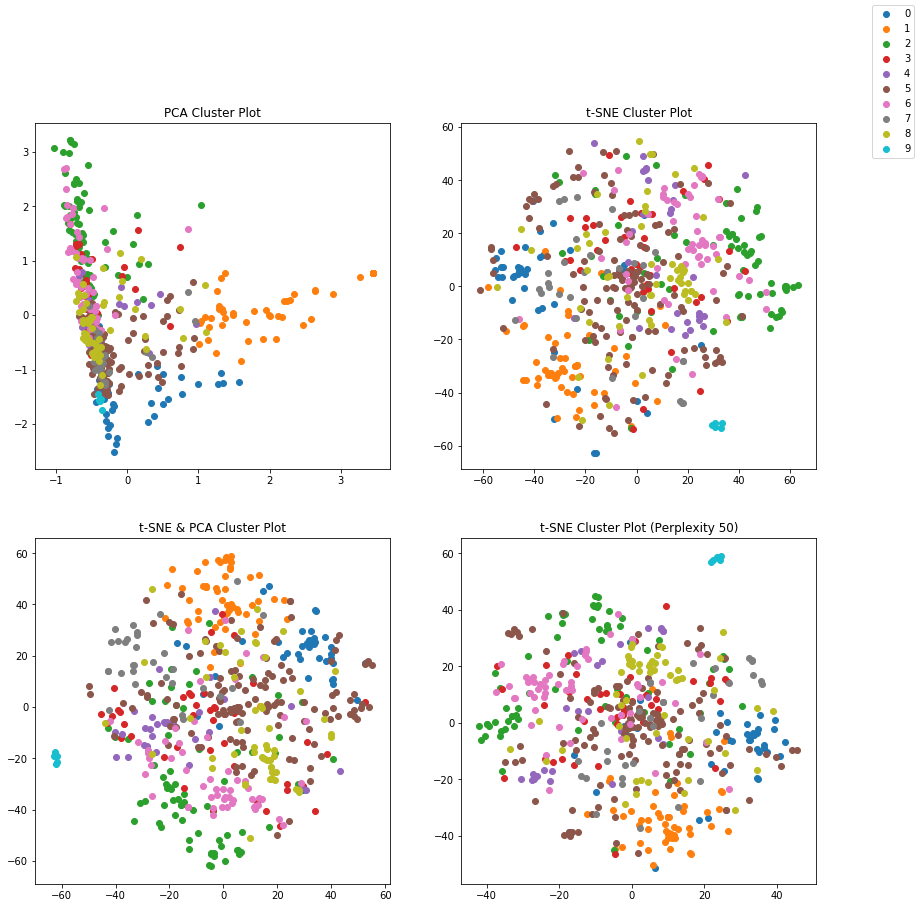

In [10]:
print("text shape:", text.shape)
print("clusters:", clusters.shape, clusters)
plot_tsne_pca(text.todense(), clusters)

## Get keywords of each clusters

In [11]:
def get_top_keywords(data, text, clusters, labels, n_terms):
    text_feature = text.toarray()
    data = np.array(data)
    labels = np.array(labels)
    group = pd.DataFrame(text.todense()).groupby(clusters)
    #print("Data point in each group:\n", group.size())
    df = group.mean() # [(clusters) rows x (feature) columns]

    for i,r in df.iterrows():
        #print(text_feature[clusters == i,:])
        sub_text = data[clusters == i]
        sub_text_list = sub_text.tolist()
        sub_text_feature = text_feature[clusters == i]
        #print("sub_text: {} | sub_text_feature: {}".format(sub_text.shape,sub_text_feature.shape))
        dist = np.linalg.norm(sub_text_feature - np.array(r), axis=1)

        #print("Euclidean distance:", dist.shape, dist)
        
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
        #print(','.join([str(r[t]) for t in np.argsort(r)[-n_terms:]]))
        print("")
        print('\n\n'.join([re.sub(' +', ' ',_filter(sub_text_list[t])) + " | " + str(dist[t]) for t in np.argsort(dist)[-2:]]))
            
get_top_keywords(reduced_data, text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
clip,play,make,try,audio,produce,file,use,edit,video

when I hit the PRODUCE button kicks me out of Power Director | 1.0272319686322555

When I hit the produce button it  | 1.0272319686322555

Cluster 1
try,screen,help,good,photo,error,video,app,file,attach

Why I can t overlay more tracks I thought up to track when I subscribe But why can t I only track Attach File Attach File  | 1.005259761599659

RE QuestionID Further to my reply today please also see the DxDiag bit report Attach File  | 1.0059653610134889

Cluster 2
purchase,ultra,product,software,send,need,number,order,link,download

IPlease I cannot fill the SR number Willem | 1.0199282589691578

MY INVOICE NUMBER IS OR CONFIRMATION IS  | 1.0201161897278315

Cluster 3
thank,number,address,use,need,software,product,download,email,purchase

how to type email | 1.0084370766909048

Hi I just purchased the ultra and it has other downloads listed that there my downloads will these downloads cost extra | 1.0130120430059244

C

## Test

In [12]:
def top_tfidf_feats(row, features, top_n=50):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df
def top_feats_in_doc(Xtr, features, row_id, top_n=50):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

top_feats_in_doc(text,tfidf.get_feature_names(),2)

,feature,tfidf
0,order,0.369761
1,end,0.286175
2,mail,0.271268
3,enter,0.270460
4,download,0.266151
5,best,0.260259
6,trial,0.244113
7,year,0.233793
8,regard,0.214041
9,make,0.212241


## Doc2vec Clustering

In [13]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [15]:
tagged_data = [TaggedDocument(words=tokens, tags=[str(i)]) for i, tokens in enumerate(token_data)]

In [16]:
max_epochs = 100
alpha = 0.025

model = Doc2Vec(vector_size=max_features,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=1)
  
model.build_vocab(tagged_data)
bar = tqdm(range(max_epochs))
for epoch in bar:
    bar.set_description('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")


iteration 1:   1%|          | 1/100 [00:22<37:23, 22.66s/it]

KeyboardInterrupt: 

In [ ]:
#model= Doc2Vec.load("d2v.model")
model= Doc2Vec.load("enwiki_dbow/doc2vec.bin")
'''
#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)


# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])
'''

n_data = len(reduced_data)
docvec = []
for i in tqdm(range(n_data)):
    #docvec.append(model.docvecs[str(i)])
    docvec.append(model.infer_vector(token_data[i]))
docvec = np.array(docvec)
print("Number of data: {}".format(n_data))

In [ ]:
find_optimal_clusters(docvec, max_k, batch_size)

In [ ]:
clusters_docvec = MiniBatchKMeans(n_clusters=10, batch_size=batch_size, random_state=20).fit_predict(docvec)
print("docvec shape:", docvec.shape)
print("clusters:", clusters_docvec.shape, clusters_docvec)
plot_tsne_pca(docvec, clusters_docvec)

In [ ]:
def get_doc2vec_center_representation(data, docvec, clusters, n_sentence):
    data = np.array(data)
    #print(len(data))
    #print(clusters.shape)
    print("docvec shape", docvec.shape)
    group = pd.DataFrame(docvec).groupby(clusters)
    #print("Data point in each group:\n", group.size())
    df = group.mean() # [(clusters) rows x (feature) columns]

    for i,r in df.iterrows():
        #print(text_feature[clusters == i,:])
        sub_text = data[clusters == i]
        sub_text_list = sub_text.tolist()
        sub_docvec = docvec[clusters == i]
        #print("sub_text: {} | sub_text_feature: {}".format(sub_text.shape,sub_text_feature.shape))
        dist = np.linalg.norm(sub_docvec - np.array(r), axis=1)

        #print("Euclidean distance:", dist.shape, dist)
        
        print('\nCluster {}'.format(i))
        print('\n\n'.join([re.sub(' +', ' ',_filter(sub_text_list[t])) + " | " + str(dist[t]) for t in np.argsort(dist)[-2:]]))
            
get_doc2vec_center_representation(reduced_data, docvec, clusters_docvec, 2)

### Reference
* [Clustering documents with TFIDF and KMeans](https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans)
* [Analyzing tf-idf results in scikit-learn](https://buhrmann.github.io/tfidf-analysis.html)

In [19]:
import gensim
from gensim.models import LdaMulticore

dictionary = gensim.corpora.Dictionary(token_data)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in token_data]

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

### LDA using BOW

In [20]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=16)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.018*"purchase" + 0.016*"file" + 0.015*"download" + 0.015*"use" + 0.013*"attach" + 0.013*"dvd" + 0.012*"please" + 0.012*"product" + 0.012*"would" + 0.012*"new"
Topic: 1 
Words: 0.035*"new" + 0.027*"download" + 0.022*"purchase" + 0.018*"version" + 0.018*"computer" + 0.017*"use" + 0.016*"product" + 0.016*"need" + 0.015*"order" + 0.014*"key"
Topic: 2 
Words: 0.044*"order" + 0.024*"purchase" + 0.023*"number" + 0.020*"please" + 0.018*"download" + 0.017*"product" + 0.015*"install" + 0.014*"key" + 0.012*"email" + 0.012*"program"
Topic: 3 
Words: 0.065*"file" + 0.054*"attach" + 0.036*"download" + 0.014*"buy" + 0.013*"get" + 0.013*"software" + 0.013*"please" + 0.013*"install" + 0.012*"computer" + 0.011*"link"
Topic: 4 
Words: 0.058*"download" + 0.031*"link" + 0.031*"file" + 0.021*"product" + 0.021*"attach" + 0.020*"key" + 0.018*"purchase" + 0.017*"send" + 0.015*"please" + 0.013*"order"
Topic: 5 
Words: 0.031*"video" + 0.016*"use" + 0.010*"file" + 0.010*"work" + 0.009*"would" +

### LDA using TF-IDF

In [21]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=16)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.011*"download" + 0.010*"order" + 0.009*"new" + 0.009*"attach" + 0.009*"file" + 0.009*"want" + 0.009*"install" + 0.009*"link" + 0.008*"computer" + 0.008*"purchase"
Topic: 1 Word: 0.013*"download" + 0.011*"link" + 0.010*"attach" + 0.010*"file" + 0.009*"purchase" + 0.007*"want" + 0.007*"order" + 0.007*"please" + 0.007*"product" + 0.007*"find"
Topic: 2 Word: 0.016*"file" + 0.015*"attach" + 0.014*"video" + 0.007*"download" + 0.006*"get" + 0.006*"produce" + 0.006*"audio" + 0.006*"use" + 0.005*"version" + 0.005*"try"
Topic: 3 Word: 0.012*"attach" + 0.011*"file" + 0.011*"correspondence" + 0.009*"please" + 0.008*"use" + 0.008*"download" + 0.008*"test" + 0.007*"name" + 0.007*"attachment" + 0.007*"copy"
Topic: 4 Word: 0.008*"ray" + 0.007*"attach" + 0.007*"file" + 0.007*"download" + 0.007*"unable" + 0.007*"blu" + 0.007*"please" + 0.007*"refund" + 0.006*"purchase" + 0.006*"play"
Topic: 5 Word: 0.062*"attach" + 0.055*"file" + 0.012*"download" + 0.007*"good" + 0.007*"link" + 0.007*"p